In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from lib.functions import plot_confusion_matrix
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Data loading

In [2]:
df = pd.read_csv('../data/mushrooms_v2.csv')
print(df.shape)
print(df.columns)
df.head()

(8124, 23)
Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,s,f,g,t,p,f,d,n,k,...,s,c,c,p,w,t,p,k,n,u
1,e,x,g,y,t,a,d,c,b,k,...,y,e,e,p,w,o,p,u,a,p
2,e,k,s,n,t,l,f,w,b,n,...,k,b,b,p,w,o,p,n,v,g
3,p,b,y,w,t,y,f,c,n,e,...,k,w,g,p,w,b,n,k,s,u
4,e,b,s,g,f,n,n,c,b,o,...,s,w,e,p,w,b,z,w,a,g


# Data exploration

Frequency of variable class


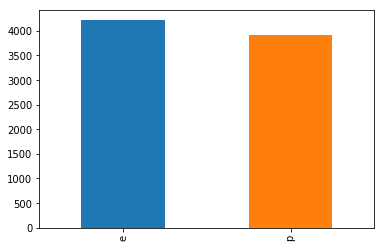

Contingency table for variable class
class     e     p   All
class                  
e      4208     0  4208
p         0  3916  3916
All    4208  3916  8124
----------
Frequency of variable cap-shape


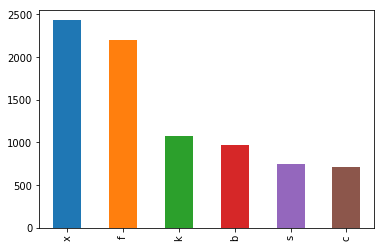

Contingency table for variable cap-shape
cap-shape    b    c     f     k    s     x   All
class                                           
e          590  379  1152   450  376  1261  4208
p          378  336  1043   625  366  1168  3916
All        968  715  2195  1075  742  2429  8124
----------
Frequency of variable cap-surface


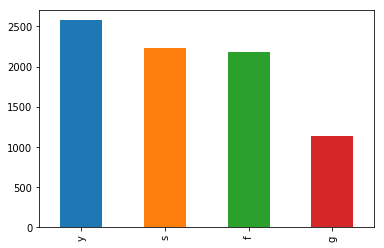

Contingency table for variable cap-surface
cap-surface     f     g     s     y   All
class                                    
e            1253   602  1102  1251  4208
p             929   539  1125  1323  3916
All          2182  1141  2227  2574  8124
----------
Frequency of variable cap-color


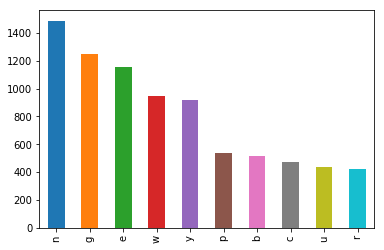

Contingency table for variable cap-color
cap-color    b    c     e     g     n    p    r    u    w    y   All
class                                                               
e          259  235   508   679   823  260  236  227  569  412  4208
p          255  234   646   566   665  276  186  212  374  502  3916
All        514  469  1154  1245  1488  536  422  439  943  914  8124
----------
Frequency of variable bruises


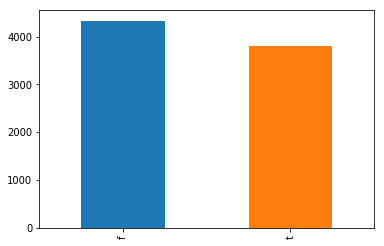

Contingency table for variable bruises
bruises     f     t   All
class                    
e        1792  2416  4208
p        2537  1379  3916
All      4329  3795  8124
----------
Frequency of variable odor


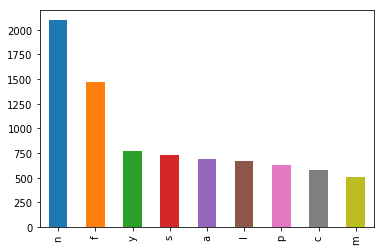

Contingency table for variable odor
odor     a    c     f    l    m     n    p    s    y   All
class                                                     
e      448  255   259  438  251  1829  266  223  239  4208
p      241  321  1209  228  253   269  360  506  529  3916
All    689  576  1468  666  504  2098  626  729  768  8124
----------
Frequency of variable gill-attachment


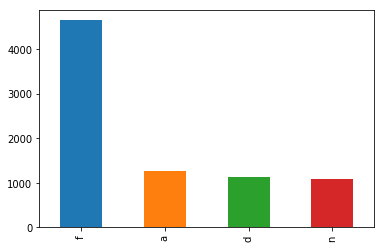

Contingency table for variable gill-attachment
gill-attachment     a     d     f     n   All
class                                        
e                 666   592  2385   565  4208
p                 593   534  2259   530  3916
All              1259  1126  4644  1095  8124
----------
Frequency of variable gill-spacing


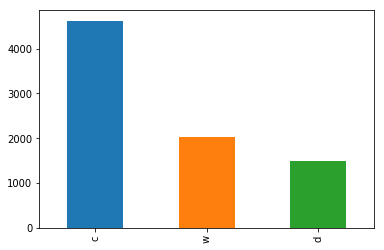

Contingency table for variable gill-spacing
gill-spacing     c     d     w   All
class                               
e             2188   732  1288  4208
p             2438   749   729  3916
All           4626  1481  2017  8124
----------
Frequency of variable gill-size


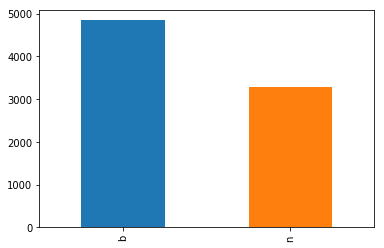

Contingency table for variable gill-size
gill-size     b     n   All
class                      
e          2976  1232  4208
p          1867  2049  3916
All        4843  3281  8124
----------
Frequency of variable gill-color


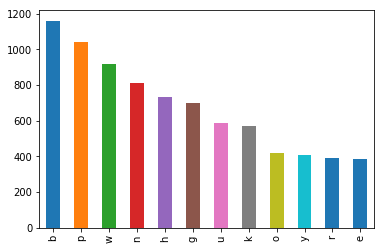

Contingency table for variable gill-color
gill-color     b    e    g    h    k    n    o     p    r    u    w    y   All
class                                                                         
e            196  213  313  313  330  610  241   594  184  390  618  206  4208
p            965  171  384  422  240  203  180   448  207  195  297  204  3916
All         1161  384  697  735  570  813  421  1042  391  585  915  410  8124
----------
Frequency of variable stalk-shape


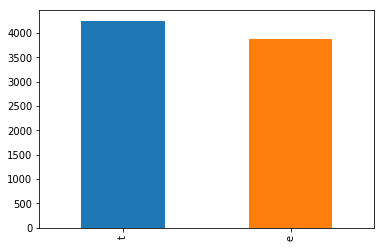

Contingency table for variable stalk-shape
stalk-shape     e     t   All
class                        
e            1919  2289  4208
p            1954  1962  3916
All          3873  4251  8124
----------
Frequency of variable stalk-root


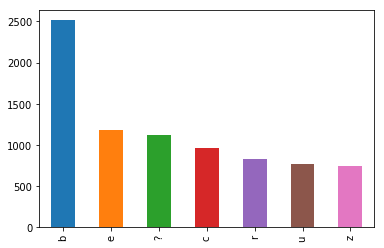

Contingency table for variable stalk-root
stalk-root     ?     b    c     e    r    u    z   All
class                                                 
e            320  1302  602   750  458  397  379  4208
p            801  1211  361   427  370  375  371  3916
All         1121  2513  963  1177  828  772  750  8124
----------
Frequency of variable stalk-surface-above-ring


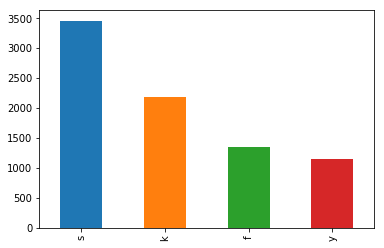

Contingency table for variable stalk-surface-above-ring
stalk-surface-above-ring     f     k     s     y   All
class                                                 
e                          741   627  2236   604  4208
p                          602  1551  1222   541  3916
All                       1343  2178  3458  1145  8124
----------
Frequency of variable stalk-surface-below-ring


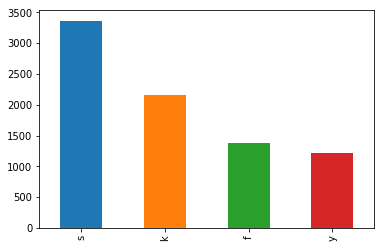

Contingency table for variable stalk-surface-below-ring
stalk-surface-below-ring     f     k     s     y   All
class                                                 
e                          788   634  2122   664  4208
p                          599  1526  1241   550  3916
All                       1387  2160  3363  1214  8124
----------
Frequency of variable stalk-color-above-ring


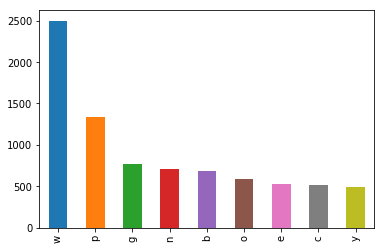

Contingency table for variable stalk-color-above-ring
stalk-color-above-ring    b    c    e    g    n    o     p     w    y   All
class                                                                      
e                       236  268  313  502  265  351   523  1514  236  4208
p                       447  250  212  267  444  241   818   987  250  3916
All                     683  518  525  769  709  592  1341  2501  486  8124
----------
Frequency of variable stalk-color-below-ring


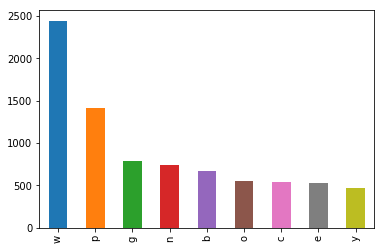

Contingency table for variable stalk-color-below-ring
stalk-color-below-ring    b    c    e    g    n    o     p     w    y   All
class                                                                      
e                       247  263  326  542  285  314   539  1477  215  4208
p                       418  271  207  244  452  235   872   969  248  3916
All                     665  534  533  786  737  549  1411  2446  463  8124
----------
Frequency of variable veil-type


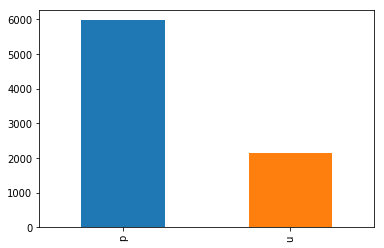

Contingency table for variable veil-type
veil-type     p     u   All
class                      
e          3064  1144  4208
p          2904  1012  3916
All        5968  2156  8124
----------
Frequency of variable veil-color


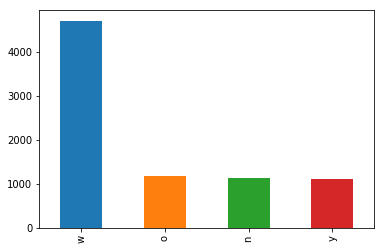

Contingency table for variable veil-color
veil-color     n     o     w     y   All
class                                   
e            600   644  2402   562  4208
p            535   538  2301   542  3916
All         1135  1182  4703  1104  8124
----------
Frequency of variable ring-number


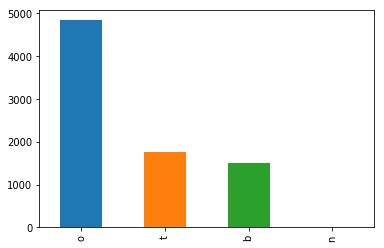

Contingency table for variable ring-number
ring-number     b   n     o     t   All
class                                  
e             815   0  2394   999  4208
p             694  11  2441   770  3916
All          1509  11  4835  1769  8124
----------
Frequency of variable ring-type


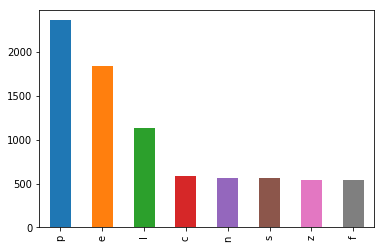

Contingency table for variable ring-type
ring-type    c     e    f     l    n     p    s    z   All
class                                                     
e          304   744  295   298  281  1721  291  274  4208
p          284  1098  244   830  286   637  270  267  3916
All        588  1842  539  1128  567  2358  561  541  8124
----------
Frequency of variable spore-print-color


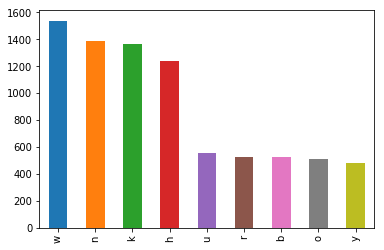

Contingency table for variable spore-print-color
spore-print-color    b     h     k     n    o    r    u     w    y   All
class                                                                   
e                  279   269  1026  1053  267  248  322   516  228  4208
p                  245   972   341   335  243  279  229  1022  250  3916
All                524  1241  1367  1388  510  527  551  1538  478  8124
----------
Frequency of variable population


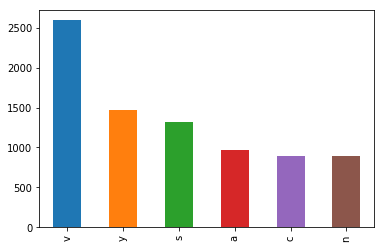

Contingency table for variable population
population    a    c    n     s     v     y   All
class                                            
e           590  531  546   793   927   821  4208
p           374  368  347   520  1664   643  3916
All         964  899  893  1313  2591  1464  8124
----------
Frequency of variable habitat


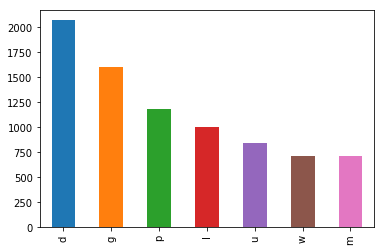

Contingency table for variable habitat
habitat     d     g     l    m     p    u    w   All
class                                               
e        1195   963   447  400   408  395  400  4208
p         877   636   558  311   772  450  312  3916
All      2072  1599  1005  711  1180  845  712  8124
----------


In [3]:
for c in df.columns:
    print('Frequency of variable', c)
    df[c].value_counts().plot.bar()
    plt.show()
    class_var = pd.crosstab(index=df["class"], 
                    columns=df[c],
                     margins=True)   # Include row and column totals

#     survived_class.columns = ["class1","class2","class3","rowtotal"]
#     survived_class.index= ["died","survived","coltotal"]
    print('Contingency table for variable', c)
    print(class_var)
    print('----------')

# Model training

In [4]:
X=df.drop(labels=['class'], axis=1)
X=pd.get_dummies(X)

y=pd.get_dummies(df['class'], drop_first=True) # Poisonous=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(X_train.shape)
print(X_train.shape)

(6499, 127)
(6499, 127)


In [5]:
classifiers={}
classifiers['tree_5'] = DecisionTreeClassifier(min_samples_leaf = 5)
classifiers['tree_10'] = DecisionTreeClassifier(min_samples_leaf = 15)
classifiers['tree_20'] = DecisionTreeClassifier(max_depth = 10)

In [6]:
for i,clf in classifiers.items():
    clf.fit(X_train,y_train)
    print(i)
    print('Accuracy: '+str(clf.score(X_test,y_test)))
    y_pred = clf.predict(X_test)
    pickle.dump(clf, open('../models/'+i+'.pickle', 'wb'))

tree_5
Accuracy: 0.832
tree_10
Accuracy: 0.841846153846
tree_20
Accuracy: 0.827692307692


# Model selection
We should minimize poisonous classified as edible i.e. false negatives (when poisounous=1)

tree_5
Accuracy: 0.832
AUC: 0.896935973297


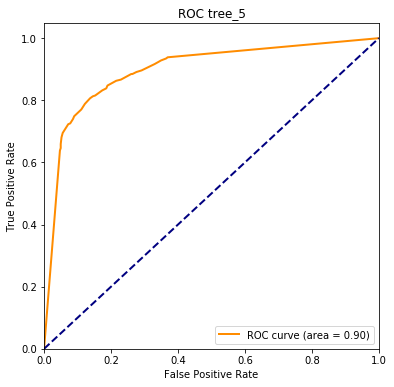

Confusion matrix, without normalization
[[721 124]
 [156 624]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.2   0.8 ]]


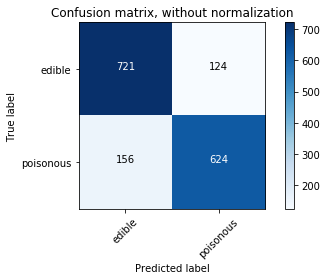

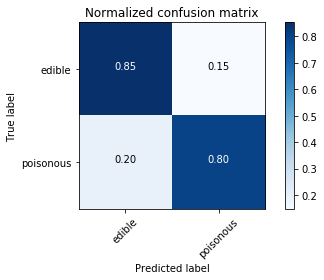

tree_10
Accuracy: 0.841846153846
AUC: 0.915892125626


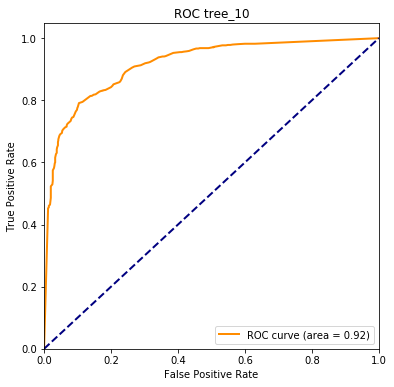

Confusion matrix, without normalization
[[721 124]
 [156 624]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.2   0.8 ]]


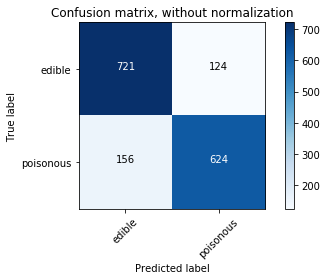

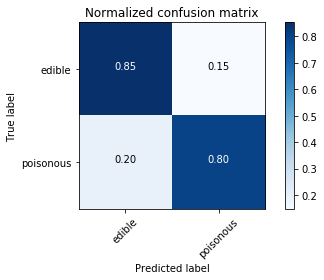

tree_20
Accuracy: 0.827692307692
AUC: 0.872530723714


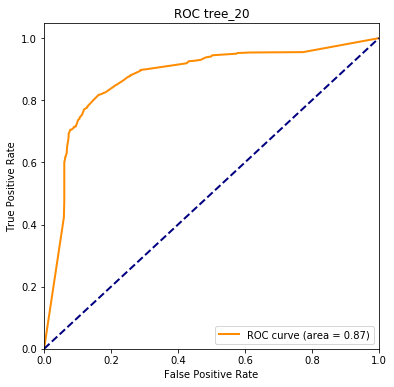

Confusion matrix, without normalization
[[721 124]
 [156 624]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.2   0.8 ]]


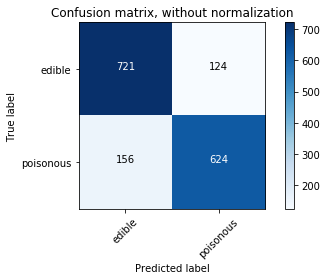

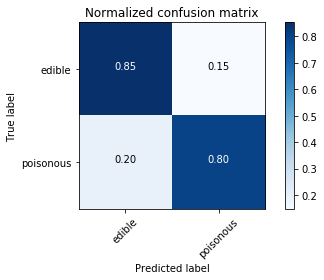

In [7]:
for i,clf in classifiers.items():
    print(i)
    print('Accuracy: '+str(clf.score(X_test,y_test)))

    # display ROC Curve
    y_true = y_test
    y_score = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr,tpr)
    print('AUC: '+str(roc_auc))

    plt.figure(figsize=(6,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC '+i)
    plt.legend(loc="lower right")
    #     plt.savefig('plots/roc/'+str(i)+'.png', bbox_inches='tight')
    plt.show()
    
    
    
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['edible', 'poisonous'],
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['edible', 'poisonous'], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [8]:
# test prediction
classifiers['tree_5'].predict(np.zeros(127).reshape(1, -1))

array([0], dtype=uint8)